In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [18]:
# Day2の結果
# ホールドアウト + 交差検証 + SGDClassifier
y_est = clf.predict(X_test)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

正答率 = 64.609%


In [2]:
# Day3
df_ks = pd.read_csv("ks-projects-201801.csv").drop(columns=["ID", "name", "goal", "usd pledged", "pledged", "usd_pledged_real","backers"])
df_ks = df_ks.dropna()

# convert 'state' to int-like boolean
df_ks['state'] = (df_ks['state'] == 'successful').astype(int)

# calculate time limit column
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])
df_ks['launched'] = pd.to_datetime(df_ks['launched'])
df_ks['time_limit'] = (df_ks['deadline'] - df_ks['launched']).dt.total_seconds()
df_ks.drop(columns=['launched', 'deadline'], inplace=True)

display(df_ks.head())
print(df_ks.shape)

,category,main_category,currency,state,country,usd_goal_real,time_limit
0,Poetry,Publishing,GBP,0,GB,1533.95,5053652.0
1,Narrative Film,Film & Video,USD,0,US,30000.00,5166963.0
2,Narrative Film,Film & Video,USD,0,US,45000.00,3886750.0
3,Music,Music,USD,0,US,5000.00,2579749.0
4,Film & Video,Film & Video,USD,0,US,19500.00,4807497.0


(378661, 7)


In [3]:
# Normalization
mms = MinMaxScaler()
df_ks_n = df_ks
df_ks_n[['usd_goal_real', 'time_limit']] = mms.fit_transform(df_ks_n[['usd_goal_real', 'time_limit']].values)
display(df_ks_n.head())
print(df_ks_n.shape)

,category,main_category,currency,state,country,usd_goal_real,time_limit
0,Poetry,Publishing,GBP,0,GB,0.000009,0.003494
1,Narrative Film,Film & Video,USD,0,US,0.000180,0.003572
2,Narrative Film,Film & Video,USD,0,US,0.000270,0.002687
3,Music,Music,USD,0,US,0.000030,0.001783
4,Film & Video,Film & Video,USD,0,US,0.000117,0.003324


(378661, 7)


In [4]:
# Hold Out
X = df_ks.drop(columns=["state"]).values
y = df_ks["state"].values
test_size = 0.2        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [5]:
# string列をone hot
def get_dm(df, column, th=200):
    dm = pd.get_dummies(df[[column]])
    return dm

In [6]:
# string列のtag
dm_pool = ["category","main_category","currency","country"]

# dummy column name reference
dcnr = pd.get_dummies(df_ks_n[dm_pool]).columns.tolist()

# それぞれのXをdummy
X_train_dm = pd.DataFrame()
X_test_dm = pd.DataFrame()
X_train_df = pd.DataFrame(X_train, columns=df_ks.drop(columns=["state"]).columns)
X_test_df = pd.DataFrame(X_test, columns=df_ks.drop(columns=["state"]).columns)

for i in dm_pool:
    X_train_dm = pd.concat([X_train_dm, get_dm(X_train_df, i, -1)], axis=1, sort=False) 
    X_test_dm = pd.concat([X_test_dm, get_dm(X_test_df, i, -1)], axis=1, sort=False) 

# fill lost dummy columns
X_train_dm = X_train_dm.reindex(dcnr,axis=1).fillna(0, axis=1)
X_test_dm = X_test_dm.reindex(columns=X_train_dm.columns.tolist()).fillna(0, axis=1)

display(X_train_dm.head())
print(X_train_dm.shape)
display(X_test_dm.head())
print(X_test_dm.shape)

,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(302928, 211)


,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(75733, 211)


In [7]:
# dummyと数値データを組み合わせ
X_train_dｆ_c = pd.concat([X_train_df, X_train_dm], axis=1, sort=False).drop(columns = dm_pool)
X_test_df_c = pd.concat([X_test_df, X_test_dm], axis=1, sort=False).drop(columns = dm_pool)

display(X_train_dｆ_c.head())
print(X_train_dｆ_c.shape)
display(X_test_dｆ_c.head())
print(X_test_dｆ_c.shape)

,usd_goal_real,time_limit,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.00018033,0.000971624,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.59714e-05,0.000972481,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.00012022,0.00203823,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6.07708e-05,0.00175423,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0055e-05,0.00173961,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(302928, 213)


,usd_goal_real,time_limit,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,4.8088e-05,0.00125322,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.000210385,0.0017416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.8033e-05,0.00350956,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4.2077e-05,0.0035345,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6.94608e-06,0.00174207,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(75733, 213)


In [8]:
# Assign in put
X_tr = X_train_dｆ_c.values
X_te = X_test_dｆ_c.values

In [10]:
print(X_tr.shape)
print(X_te.shape)

(302928, 213)
(75733, 213)


In [11]:
# Decision Tree 
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=1234)
clf = clf.fit(X_tr, y_train)
print("score=", clf.score(X_tr, y_train))
y_est = clf.predict(X_te)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

score= 0.8893433423123647
正答率 = 64.474%


In [12]:
# Random Forest @max_depth=3
clf = RandomForestClassifier(n_estimators=10, max_depth=3, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_tr, y_train)
print("score=", clf.score(X_tr, y_train))
y_est = clf.predict(X_te)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

score= 0.6457706121586647
正答率 = 64.811%


In [13]:
# Random Forest @max_depth=None
clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_tr, y_train)
print("score=", clf.score(X_tr, y_train))
y_est = clf.predict(X_te)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

score= 0.84655099561612
正答率 = 68.217%


In [14]:
# AdaBoost
max_depth = {1, 3, 5, 7, None}
for i in max_depth:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i,
                                                                                     min_samples_leaf=2,
                                                                                     min_samples_split=2, 
                                                                                     random_state=1234,
                                                                                     criterion="gini"),
                                               n_estimators=10, random_state=1234)
    clf.fit(X_tr, y_train)
    print("======\ndepth={}".format(str(i)))
    print("score=", clf.score(X_tr, y_train))
    y_est = clf.predict(X_te)
    print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

depth=1
score= 0.6722488512121693
正答率 = 67.610%
depth=3
score= 0.6902894417155232
正答率 = 69.330%
depth=None
score= 0.9833359742248984
正答率 = 64.500%
depth=5
score= 0.6966308825859611
正答率 = 69.826%
depth=7
score= 0.7012194316801352
正答率 = 69.952%


In [18]:
# NN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

Using TensorFlow backend.


In [39]:
# decreace columns
pool0 = ["category","main_category","currency","country"]
pool_ref = []
dms = []

# deal with train X
for C in pool0:
    dm = pd.get_dummies(X_train_df[[C]])
    dm.loc["sum"] = dm.sum(axis=0)
    mean = np.mean(dm.loc["sum"])
    pool_other = []
    for c in dm.columns.tolist():
        if dm[c].loc["sum"] < mean:
            pool_other.append(c)
    dm[C + "_other"] = dm[pool_other].sum(axis=1)
    dm = dm.drop(columns=pool_other,index=["sum"])
    dms.append(dm)
    pool_ref.append(pool_other)
    
dms.insert(0,X_train_dｆ_c[['usd_goal_real', 'time_limit']])
X_train_df_nn = pd.concat(dms, axis=1, sort=False)

display(X_train_df_nn.head())
print(X_train_df_nn.shape)

,usd_goal_real,time_limit,category_Accessories,category_Animation,category_Apparel,category_Apps,category_Art,category_Art Books,category_Children's Books,category_Classical Music,...,main_category_Music,main_category_Publishing,main_category_Technology,main_category_other,currency_GBP,currency_USD,currency_other,country_GB,country_US,country_other
0,0.00018033,0.000971624,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1.59714e-05,0.000972481,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.00012022,0.00203823,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,6.07708e-05,0.00175423,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,3.0055e-05,0.00173961,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


(302928, 63)


In [40]:
# deal with test X, base on train X distribution
X_test_df_nn = X_test_dｆ_c.copy()
for i in range(len(pool_ref)):
    X_test_df_nn[pool0[i] + "_other"] = X_test_df_nn[pool_ref[i]].sum(axis=1)
    X_test_df_nn = X_test_df_nn.drop(columns=pool_ref[i])
X_test_df_nn = X_test_df_nn.reindex(columns=X_train_df_nn.columns.tolist())
display(X_test_df_nn.head())
print(X_test_df_nn.shape)

,usd_goal_real,time_limit,category_Accessories,category_Animation,category_Apparel,category_Apps,category_Art,category_Art Books,category_Children's Books,category_Classical Music,...,main_category_Music,main_category_Publishing,main_category_Technology,main_category_other,currency_GBP,currency_USD,currency_other,country_GB,country_US,country_other
0,4.8088e-05,0.00125322,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0.000210385,0.0017416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1.8033e-05,0.00350956,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3,4.2077e-05,0.0035345,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,6.94608e-06,0.00174207,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


(75733, 63)


In [59]:
X_tr_nn = X_train_df_nn.values
X_te_nn = X_test_df_nn.values
from keras.utils import np_utils
y_train_nn = np_utils.to_categorical(y_train)
y_test_nn = np_utils.to_categorical(y_test)

In [54]:
print(y_train.shape,X_tr_nn.shape)

(302928,) (302928, 63)


In [61]:
model = Sequential()
model.add(Dense(2, activation='relu'))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.1)
# -----------------------------

Train on 302928 samples, validate on 75733 samples
Epoch 1/20
302928/302928 [==============================] - 22s 74us/step - loss: 0.6508 - acc: 0.6450 - val_loss: 0.6530 - val_acc: 0.6481
Epoch 2/20
302928/302928 [==============================] - 22s 71us/step - loss: 0.6546 - acc: 0.6453 - val_loss: 0.6725 - val_acc: 0.6481
Epoch 3/20
302928/302928 [==============================] - 22s 72us/step - loss: 0.6546 - acc: 0.6452 - val_loss: 0.6558 - val_acc: 0.6481
Epoch 4/20
302928/302928 [==============================] - 22s 71us/step - loss: 0.6546 - acc: 0.6455 - val_loss: 0.6500 - val_acc: 0.6481
Epoch 5/20
302928/302928 [==============================] - 21s 69us/step - loss: 0.6543 - acc: 0.6454 - val_loss: 0.6489 - val_acc: 0.6481
Epoch 6/20
302928/302928 [==============================] - 22s 72us/step - loss: 0.6547 - acc: 0.6456 - val_loss: 0.6500 - val_acc: 0.6481
Epoch 7/20
302928/302928 [==============================] - 23s 75us/step - loss: 0.6547 - acc: 0.6453 - val_

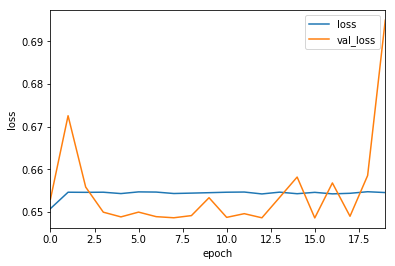

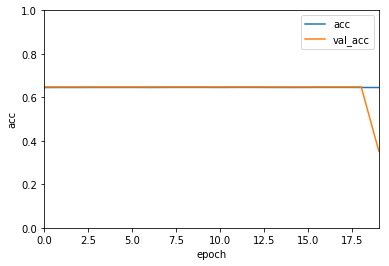

Train on 302928 samples, validate on 75733 samples
Epoch 1/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6545 - acc: 0.6452 - val_loss: 0.6607 - val_acc: 0.6481
Epoch 2/20
302928/302928 [==============================] - 23s 78us/step - loss: 0.6545 - acc: 0.6457 - val_loss: 0.6486 - val_acc: 0.6481
Epoch 3/20
302928/302928 [==============================] - 24s 78us/step - loss: 0.6545 - acc: 0.6453 - val_loss: 0.6569 - val_acc: 0.6481
Epoch 4/20
302928/302928 [==============================] - 23s 76us/step - loss: 0.6547 - acc: 0.6455 - val_loss: 0.6489 - val_acc: 0.6481
Epoch 5/20
302928/302928 [==============================] - 23s 76us/step - loss: 0.6545 - acc: 0.6454 - val_loss: 0.6488 - val_acc: 0.6481
Epoch 6/20
302928/302928 [==============================] - 23s 76us/step - loss: 0.6546 - acc: 0.6457 - val_loss: 0.6498 - val_acc: 0.6481
Epoch 7/20
302928/302928 [==============================] - 23s 76us/step - loss: 0.6545 - acc: 0.6453 - val_

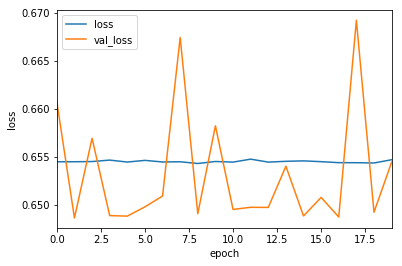

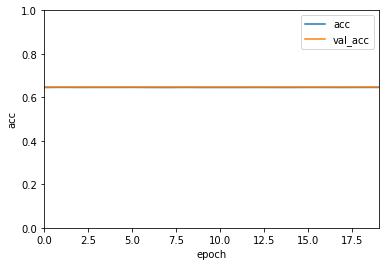

Train on 302928 samples, validate on 75733 samples
Epoch 1/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6544 - acc: 0.6453 - val_loss: 0.6851 - val_acc: 0.6481
Epoch 2/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6544 - acc: 0.6453 - val_loss: 0.6502 - val_acc: 0.6481
Epoch 3/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6545 - acc: 0.6457 - val_loss: 0.6510 - val_acc: 0.6481
Epoch 4/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6544 - acc: 0.6456 - val_loss: 0.6534 - val_acc: 0.6481
Epoch 5/20
302928/302928 [==============================] - 23s 76us/step - loss: 0.6544 - acc: 0.6454 - val_loss: 0.6506 - val_acc: 0.6481
Epoch 6/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6549 - acc: 0.6454 - val_loss: 0.6503 - val_acc: 0.6481
Epoch 7/20
302928/302928 [==============================] - 23s 77us/step - loss: 0.6543 - acc: 0.6456 - val_

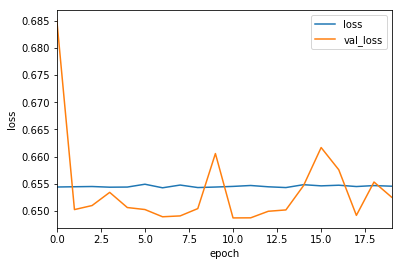

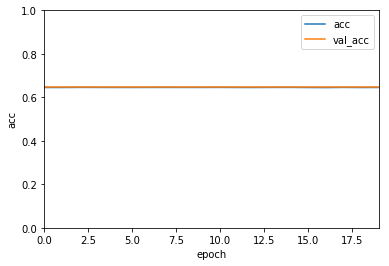

In [62]:
lr = [0.1, 0.01, 0.001]

# 学習率をチェンジしながらモデルのパフォーマンスを向上したいですが、
# こいうやり方で有効なのかは確定できません。
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.1),
              metrics=['accuracy'])
for i in lr:
    model.optimizer = Adam(lr=i)

    fit = model.fit(X_tr_nn, y_train_nn,
              epochs=20,
              batch_size=24,validation_data=(X_te_nn, y_test_nn))

    # 各epochにおける損失と精度をdfに入れる
    df = pd.DataFrame(fit.history)

    # グラフ化
    df[["loss", "val_loss"]].plot()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()

    df[["acc", "val_acc"]].plot()
    plt.ylabel("acc")
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()

In [63]:
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()

weights[0]=
[[ 1.43327981e-01  3.41440811e+01]
 [-1.18508115e-01  1.31990778e+00]
 [-3.09441090e-01 -9.17081714e-01]
 [-2.08422214e-01 -1.59003127e+00]
 [ 2.71164417e-01 -1.07158413e-02]
 [-5.01869321e-02  7.15788174e+00]
 [-4.87965047e-02 -7.65986204e-01]
 [ 1.90538615e-01 -2.33232093e+00]
 [-1.40416488e-01 -2.16060117e-01]
 [ 1.48509115e-01 -1.23887849e+00]
 [ 2.21536160e-02 -1.54126883e+00]
 [ 6.73624277e-02 -4.96948528e+00]
 [ 1.34962797e-01 -1.13203502e+00]
 [-1.13127604e-01  2.90486664e-01]
 [-2.88729608e-01 -2.09891334e-01]
 [-2.09713846e-01 -1.00772214e+00]
 [ 9.58207846e-02  4.55869704e-01]
 [ 2.44912684e-01  7.16020584e-01]
 [-6.24030828e-04  3.40830755e+00]
 [-2.74347663e-02  1.26183295e+00]
 [-1.28309771e-01  2.73136067e+00]
 [ 2.90149450e-01 -3.24273229e+00]
 [ 4.07428443e-02  1.75922692e+00]
 [-2.43601352e-01 -2.52899075e+00]
 [-3.74060571e-02  2.62425804e+00]
 [ 2.07618535e-01 -1.49215913e+00]
 [-2.93830454e-01  3.09724957e-01]
 [-2.84993023e-01 -3.06616366e-01]
 [ 2.973

In [64]:
from keras.models import load_model

# 保存
model.save('my_model.h5')
del model

# 読み込み
model = load_model('my_model.h5')

In [68]:
y_pred = np.argmax(model.predict(X_te_nn),axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])